In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import h5py
import re
from astropy.time import Time
from matplotlib.colors import LinearSegmentedColormap
from mc3.stats import time_avg


In [2]:
eclipse = ['1']
aperture = ['5']
#aperture = ['4', '7', '12']
segments = ['0000', '0001', '0002', '0003', '0004']

# Initialize dictionaries to hold arrays for each aperture
time_arr = {a: [] for a in aperture}
aplev_arr = {a: [] for a in aperture}
aperr_arr = {a: [] for a in aperture}
centroid_x_arr = {a: [] for a in aperture}
centroid_y_arr = {a: [] for a in aperture}

for a in aperture:
    for seg in segments:
        if eclipse[0] == '1':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+eclipse[0]+'/LHS1140c-S3_ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif eclipse[0] == '2':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+eclipse[0]+'/Stage3/S3_2024-07-22_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif eclipse[0] == '3':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+eclipse[0]+'/Stage3/S3_2024-08-05_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        with h5py.File(path, 'r') as file:     # open the file
            time_arr[a] = np.append(time_arr[a], np.array(file['time']))
            aplev_arr[a] = np.append(aplev_arr[a], np.array(file['aplev']))
            aperr_arr[a] = np.append(aperr_arr[a], np.array(file['aperr']))
            centroid_x_arr[a] = np.append(centroid_x_arr[a], np.array(file['centroid_x']))
            centroid_y_arr[a] = np.append(centroid_y_arr[a], np.array(file['centroid_y']))

    time_arr[a] = np.array(time_arr[a])
    aplev_arr[a] = np.array(aplev_arr[a])
    aperr_arr[a] = np.array(aperr_arr[a])
    centroid_x_arr[a] = np.array(centroid_x_arr[a])
    centroid_y_arr[a] = np.array(centroid_y_arr[a])
    
print(time_arr['5'])

[60275.77646891 60275.77659717 60275.77672543 ... 60275.93794689
 60275.93807515 60275.93820341]


In [3]:
# remove the first 2 points, rename arrays, normalize and set t_s = 0
ndiscard = 2
time = time_arr['5'][ndiscard:]
aplev = aplev_arr['5'][ndiscard:]
aperr = aperr_arr['5'][ndiscard:]
centroid_x = centroid_x_arr['5'][ndiscard:]
centroid_y = centroid_y_arr['5'][ndiscard:]

# set up parameters and set t_s = 0
eclipse = Time('2023-11-27 21:00', format = 'iso', scale = 'tdb')
eclipse = eclipse.mjd
eclipse = (eclipse-time[0])*24
e_dur = 1.13 # hours
e_dur_days = e_dur / 24
time = (time - time[0])*(24)

aperr = aperr / np.mean(aplev)
aplev = aplev / np.mean(aplev)

In [4]:
def extract_mcmc_parameters(file_path):
    # Read the file content
    with open(file_path, "r") as file:
        data = file.read()
    
    # Extract key-value pairs using regular expressions
    results = re.findall(r'(\S+)\s*=\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)\s*(\+\d*\.?\d+(?:[eE][-+]?\d+)?)?\s*(\-\d*\.?\d+(?:[eE][-+]?\d+)?)?', data)
    
    # Store results in a dictionary
    parameters = {}
    for result in results:
        key = result[0]
        value = float(result[1])
        plus_err = float(result[2]) if result[2] else None
        minus_err = float(result[3]) if result[3] else None
        parameters[key] = {
            "value": value,
            "plus_err": plus_err,
            "minus_err": minus_err
        }
    
    return parameters

#models = ['linear', 'exp', 'exp+linear', 'exp+polynomial', 'polynomial', 'exp_2nd_order_centroid']
models = ['exp', 'exp+linear', 'exp+polynomial', 'polynomial', 'double_exp', 'exp_2nd_order_centroid', 'exp+polynomial_2nd_order_centroid', 'exp+linear_2nd_order_centroid', 'polynomial_2nd_order_centroid', 'double_exp_2nd_order_centroid']
parameters = {model: [] for model in models}

for model in models:
    file = 'MCMC_results/ecl1_' + model + '_test_results.txt'
    parameters[model] = extract_mcmc_parameters(file)
    print(model, parameters[model])


exp {'t_s': {'value': 2.3547243614739815, 'plus_err': 0.045854173692250644, 'minus_err': -0.0527589061881546}, 'fp': {'value': 0.00032398707243913577, 'plus_err': 5.360428359960632e-05, 'minus_err': -5.410135642869773e-05}, 'c_1': {'value': 0.0034604447608135407, 'plus_err': 9.410675957610823e-05, 'minus_err': -9.73657101093618e-05}, 'c_2': {'value': 2.135798552069624, 'plus_err': 0.06718036619464707, 'minus_err': -0.07133297468438293}, 'c_3': {'value': 0.9993458094628047, 'plus_err': 4.3435121287571654e-05, 'minus_err': -4.368229554829739e-05}, 'c_4': {'value': 0.0008097972210384756, 'plus_err': 1.6361233582886324e-05, 'minus_err': -1.581573278333615e-05}, 'RMS': {'value': 810.553281638424, 'plus_err': None, 'minus_err': None}, 'chi2': {'value': 1261.803615472046, 'plus_err': None, 'minus_err': None}, 'BIC': {'value': -16634.554431339307, 'plus_err': None, 'minus_err': None}}
exp+linear {'t_s': {'value': 2.3498684189533745, 'plus_err': 0.01386041209878508, 'minus_err': -0.012102833318

bic_values_dict is  {'exp': 7.142585662670172, 'exp+linear': 17.275013713184308, 'exp+polynomial': 22.326735191098123, 'polynomial': 40.040534590494644, 'double_exp': 10.015667594034312, 'exp_2nd_order_centroid': 0.0, 'exp+polynomial_2nd_order_centroid': 33.43843293181271, 'exp+linear_2nd_order_centroid': 11.467819933281135, 'polynomial_2nd_order_centroid': 27.82934377372294, 'double_exp_2nd_order_centroid': 21.640893342242634}
t_s_dict is  {'exp': 2.3547243614739815, 'exp+linear': 2.3498684189533745, 'exp+polynomial': 2.361154786380652, 'polynomial': 2.3664315429683827, 'double_exp': 2.3533190542006834, 'exp_2nd_order_centroid': 2.353837417693118, 'exp+polynomial_2nd_order_centroid': 2.3502177606556165, 'exp+linear_2nd_order_centroid': 2.344037411453768, 'polynomial_2nd_order_centroid': 2.364480766498483, 'double_exp_2nd_order_centroid': 2.3546070221245023}
fp_dict is  {'exp': 0.00032398707243913577, 'exp+linear': 0.00039325076437021354, 'exp+polynomial': 0.00031515849629186796, 'poly

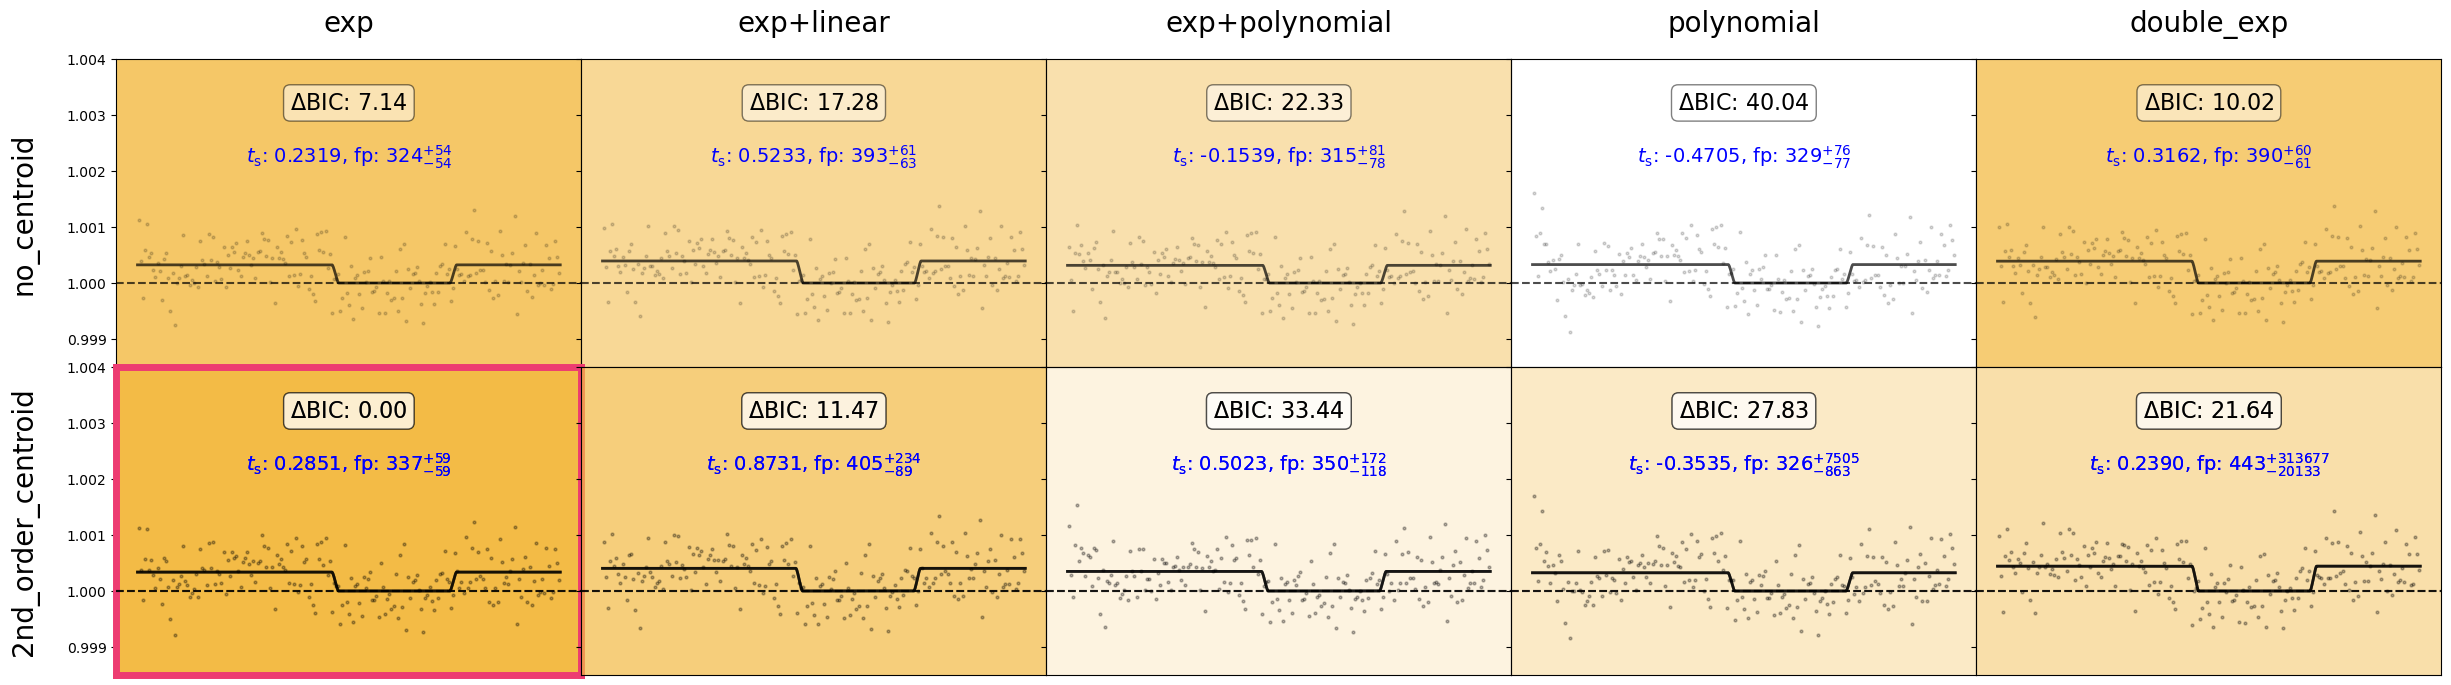

In [40]:
cols = ['exp', 'exp+linear', 'exp+polynomial', 'polynomial', 'double_exp']
rows = ['no_centroid', '2nd_order_centroid'] #'1st_order_centroid', 
minflux = 0.9985
maxflux = 1.004
color = 'yellow'

fig, subplot_dict = create_subplot_names(rows, cols, minflux=minflux, maxflux=maxflux)

mode_list = list(subplot_dict.keys())

bic_values_dict = {}
t_s_dict = {model: [] for model in models}
fp_dict = {model: [] for model in models}
fp_errp_dict = {model: [] for model in models}
fp_errm_dict = {model: [] for model in models}
for model in models:
    bic_values_dict[model], t_s_dict[model], fp_dict[model], fp_errp_dict[model], fp_errm_dict[model] = parameters[model]['BIC']['value'], parameters[model]['t_s']['value'], parameters[model]['fp']['value'], parameters[model]['fp']['plus_err'], parameters[model]['fp']['minus_err']

bic_values_dict, min_bic_key = calculate_delta_bic(bic_values_dict)

print('bic_values_dict is ', bic_values_dict)
print('t_s_dict is ', t_s_dict)
print('fp_dict is ', fp_dict)

bic_colors_dict = assign_colors_to_bic(bic_values_dict)
colors = list((assign_colors_to_bic(bic_values_dict)).values())

detec = {}
astro = {}
residuals = {}
for model in models:
    if model == 'exp+linear':
        t_s, fp, c1, c2, c3, c4, c5, sigF, RMS, chi2, BIC = [param['value'] for param in parameters['exp+linear'].values()]
        detec[model] = detec_model(time, [t_s, fp, c1, c2, c3, c4, c5, sigF], model)
        #astro[model] = transit_model(time, t_s, fp)  
        #residual[model] = (aplev / detec[model]) - astro[model]
    elif model == 'exp':
        t_s, fp, c1, c2, c3, sigF, RMS, chi2, BIC = [param['value'] for param in parameters['exp'].values()]
        detec[model] = detec_model(time, [t_s, fp, c1, c2, c3, sigF], model)
        #astro[model] = transit_model(time, t_s, fp)  
        #residual[model] = (aplev / detec[model]) - astro[model]
    elif model == 'linear':
        t_s, fp, c1, c2, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['linear'].values()]
        detec[model] = detec_model(time, [t_s, fp, c1, c2, sigF], model)
        #astro[model] = transit_model(time, t_s, fp)
        #residual[model] = (aplev / detec[model]) - astro[model]
    elif model == 'polynomial':
        t_s, fp, c1, c2, c3, c4, sigF, RMS, chi2, BIC = [param['value'] for param in parameters['polynomial'].values()]
        detec[model] = detec_model(time, [t_s, fp, c1, c2, c3, c4, sigF], model)
        #astro[model] = transit_model(time, t_s, fp) 
        #residual[model] = (aplev / detec[model]) - astro[model] 
    elif model == 'exp+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['exp+polynomial'].values()]
        detec[model] = detec_model(time, [t_s, fp, c1, c2, c3, c4, c5, c6, c7, sigF], model)
        #astro[model] = transit_model(time, t_s, fp)
        #residual[model] = (aplev / detec[model]) - astro[model]
    elif model == 'double_exp':
        t_s, fp, c1, c2, c3, c4, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['double_exp'].values()]
        detec[model] = detec_model(time, [t_s, fp, c1, c2, c3, c4, sigF], model)
        #astro[model] = transit_model(time, t_s, fp)
        #residual[model] = (aplev / detec[model]) - astro[model]  
    elif model == 'exp_2nd_order_centroid':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, c8, c9, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['exp_2nd_order_centroid'].values()]
        detec1 = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
        detec2 = detec_model(time, [t_s, fp, c7, c8, c9, sigF], 'exp')
        detec[model] = detec1*detec2
        #astro[model] = transit_model(time, t_s, fp)  
        #residual[model] = (aplev / detec[model]) - astro[model]
    elif model == 'exp+polynomial_2nd_order_centroid':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['exp+polynomial_2nd_order_centroid'].values()]
        detec1 = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
        detec2 = detec_model(time, [t_s, fp, c7, c8, c9, c10, c11, c12, c13, sigF], 'exp+polynomial')
        detec[model] = detec1*detec2
        #astro[model] = transit_model(time, t_s, fp)  
        #residual[model] = (aplev / detec[model]) - astro[model]
    elif model == 'exp+linear_2nd_order_centroid':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['exp+linear_2nd_order_centroid'].values()]
        detec1 = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
        detec2 = detec_model(time, [t_s, fp, c7, c8, c9, c10, c11, sigF], 'exp+linear')
        detec[model] = detec1*detec2
        #astro[model] = transit_model(time, t_s, fp)  
        #residual[model] = (aplev / detec[model]) - astro[model]
    elif model == 'polynomial_2nd_order_centroid':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['polynomial_2nd_order_centroid'].values()]
        detec1 = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
        detec2 = detec_model(time, [t_s, fp, c7, c8, c9, c10, sigF], 'polynomial')
        detec[model] = detec1*detec2
        #astro[model] = transit_model(time, t_s, fp)
        #residual[model] = (aplev / detec[model]) - astro[model]  
    elif model == 'double_exp_2nd_order_centroid':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['double_exp_2nd_order_centroid'].values()]
        detec1 = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
        detec2 = detec_model(time, [t_s, fp, c7, c8, c9, c10, sigF], 'double_exp')
        detec[model] = detec1*detec2
        #astro[model] = transit_model(time, t_s, fp)
    
    astro[model] = transit_model(time, t_s, fp)  
    residuals[model] = (aplev / detec[model]) - astro[model]

    if 'centroid' in model: 
        if model == min_bic_key:                            
            axes = plot_model(time, aplev, astro[model], detec[model], nbin = 200, axName=model, bic=bic_values_dict[model], t_s=eclipse-t_s_dict[model], fp=[fp_dict[model], fp_errp_dict[model], fp_errm_dict[model]], background_colors=bic_colors_dict[model], min_subplot=True)
            axes2 = plot_model(time, aplev, astro[model], detec[model], nbin = 200, axName=model, bic=bic_values_dict[model], t_s=eclipse-t_s_dict[model], fp=[fp_dict[model], fp_errp_dict[model], fp_errm_dict[model]], background_colors=bic_colors_dict[model], min_subplot=True)

        else:
            axes = plot_model(time, aplev, astro[model], detec[model], nbin = 200, axName=model, bic=bic_values_dict[model], t_s=eclipse-t_s_dict[model], fp=[fp_dict[model], fp_errp_dict[model], fp_errm_dict[model]], background_colors=bic_colors_dict[model])
            axes2 = plot_model(time, aplev, astro[model], detec[model], nbin = 200, axName=model, bic=bic_values_dict[model], t_s=eclipse-t_s_dict[model], fp=[fp_dict[model], fp_errp_dict[model], fp_errm_dict[model]], background_colors=bic_colors_dict[model])
    else:        
        if model == min_bic_key:                            
            axes = plot_model(time, aplev, astro[model], detec[model], nbin = 200, axName=model+'_no_centroid', bic=bic_values_dict[model], t_s=eclipse-t_s_dict[model], fp=[fp_dict[model], fp_errp_dict[model], fp_errm_dict[model]], background_colors=bic_colors_dict[model], min_subplot=True)
        else:
            axes = plot_model(time, aplev, astro[model], detec[model], nbin = 200, axName=model+'_no_centroid', bic=bic_values_dict[model], t_s=eclipse-t_s_dict[model], fp=[fp_dict[model], fp_errp_dict[model], fp_errm_dict[model]], background_colors=bic_colors_dict[model])

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mode exp_no_centroid plotted


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mode exp+linear_no_centroid plotted


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mode exp+polynomial_no_centroid plotted


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mode polynomial_no_centroid plotted


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mode double_exp_no_centroid plotted


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mode exp_2nd_order_centroid plotted


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mode exp+polynomial_2nd_order_centroid plotted


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mode exp+linear_2nd_order_centroid plotted


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mode polynomial_2nd_order_centroid plotted
Mode double_exp_2nd_order_centroid plotted


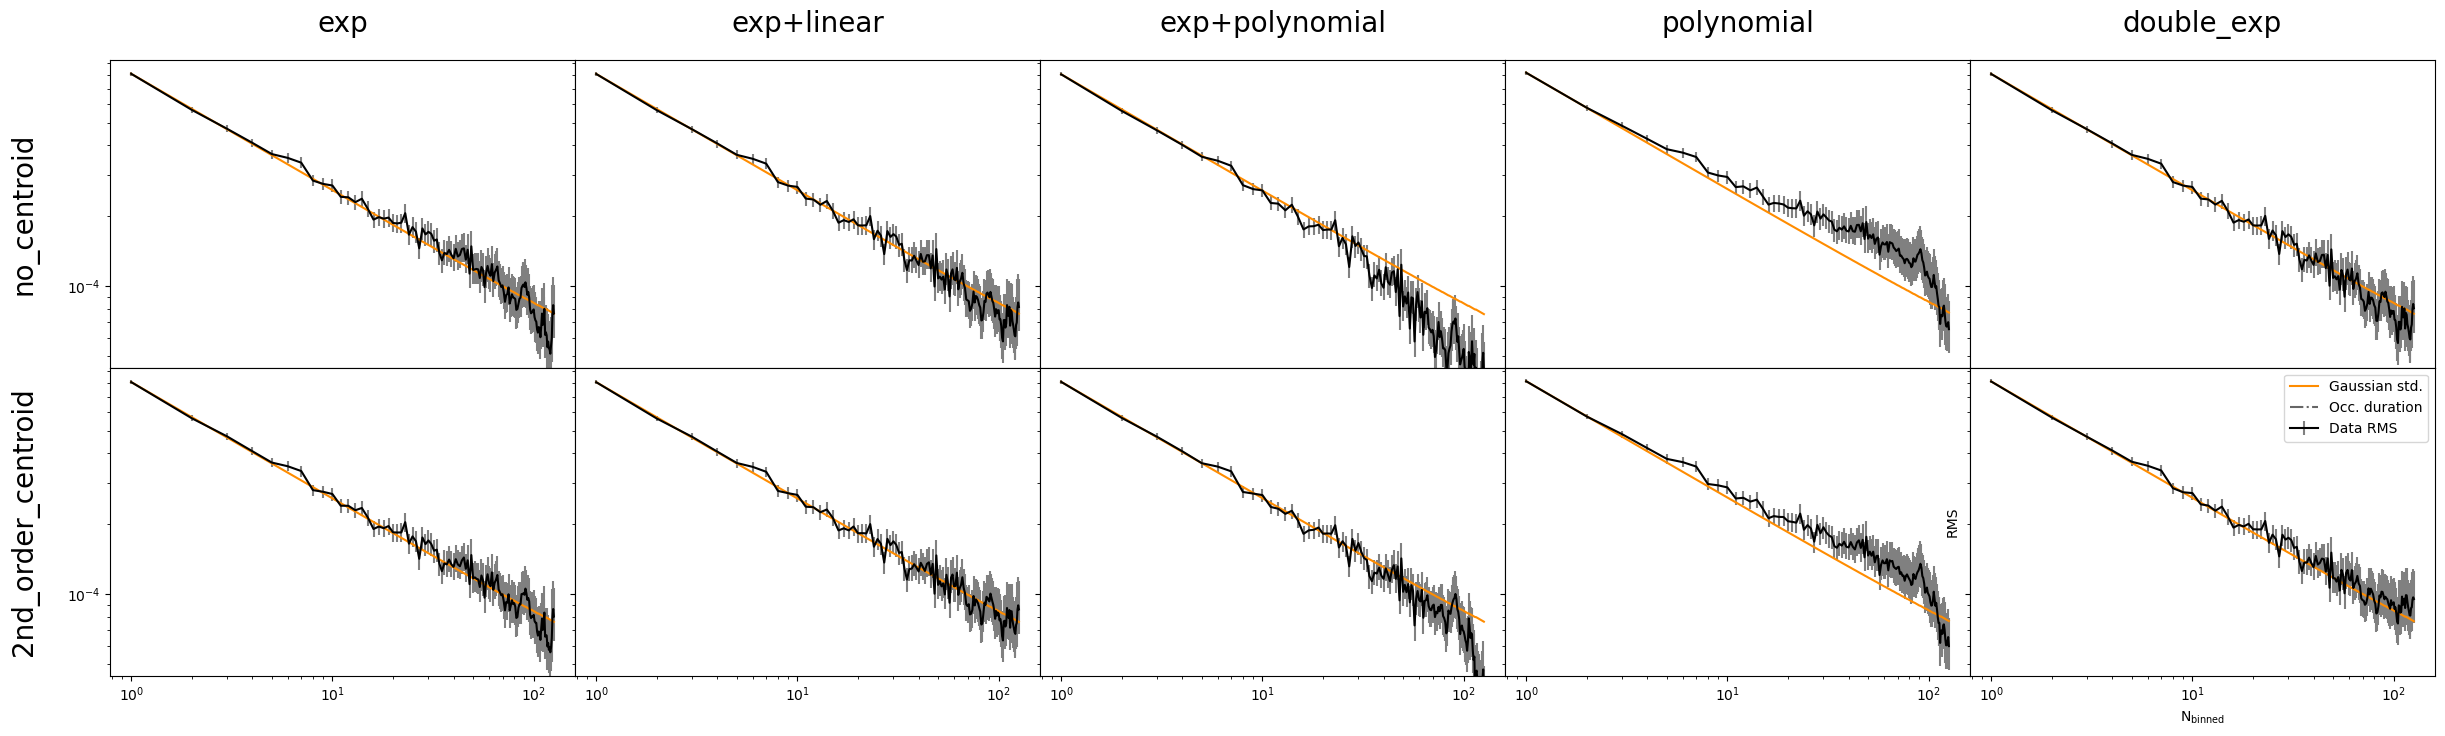

In [42]:
fig, subplot_dict = create_subplot_names(rows, cols)
mode_list = list(subplot_dict.keys())

for model in models:
    if 'centroid' in model: 
        axes = plot_rednoise(residuals[model], 10, fname='Plots/combined_plot_rednoise_test_rednoise.png', axName=model)
    else:
        axes = plot_rednoise(residuals[model], 10, fname='Plots/combined_plot_rednoise_test_rednoise.png', axName=model+'_no_centroid')
plt.show()

In [31]:
# define a few functions 
# Adapted from SPCA pipeline

text_objects = []
def create_subplot_names(rows, cols, rowslabel=None, minflux=None, maxflux=None):
    # Create a dictionary to store subplot axes and their names
    subplot_names = {}

    # Create subplots with increased spacing
    fig, axes = plt.subplots(nrows=len(rows), ncols=len(cols), sharex=True, sharey=True, figsize=(30, len(rows) * 4))

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0, hspace=0)  # Adjust the values as needed
    if minflux is not None and maxflux is not None:
        plt.ylim(minflux, maxflux)

    # Iterate through rows and columns to name the subplots
    for i, row in enumerate(rows):
        for j, col in enumerate(cols):
            subplot_name = f"{col}_{row}"  # Switched order to col_row
            ax = axes[i, j]
            subplot_names[subplot_name] = ax

            # Set the title in the middle of each subplot
            # ax.set_title(subplot_name, fontsize=15, x=0.5, y=0.5, loc="center")  # Adjust the fontsize as needed

            # Set row names as labels for y axes for the first column
            if j == 0:
                if rowslabel==None:
                    ax.set_ylabel(row, fontsize=20, labelpad=20)  # Row name as y-axis label
                else:
                    ax.set_ylabel(rowslabel[i], fontsize=20, labelpad=20)  # Row name as y-axis label
            
            # Add "No Model" text to each subplot
            text_obj = ax.text(0.5, 0.45, 'No Model', transform=ax.transAxes,
                             fontsize=18, color='grey', ha='center', va='bottom')  #, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.5))
            text_objects.append(text_obj)

    # Set column names at the top of the subplot (not as titles)
    for j, col in enumerate(cols):
        ax = axes[0, j]  # Access the top row of subplots
        ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
        ax.set_xlabel(col, fontsize=20, labelpad=20)  # Column name as x-axis label

    return fig, subplot_names

def calculate_delta_bic(bic_values_dict):
# Get the list of BIC values

    min_bic_key = min(bic_values_dict, key=lambda k: bic_values_dict[k])

    bic_values = list(bic_values_dict.values())
    min_bic = min(bic_values) # Find the minimum BIC value

    # Calculate delta BIC by subtracting the minimum BIC from each BIC value
    delta_bic_values = [bic - min_bic for bic in bic_values]

    # Create a dictionary that maps subplot names to their delta BIC values
    delta_bic_dict = {subplot_name: delta_bic for subplot_name, delta_bic in zip(bic_values_dict.keys(), delta_bic_values)}

    return delta_bic_dict, min_bic_key

def colormap(color=None):
    if color == "rosybrown":
        cmap = LinearSegmentedColormap.from_list('custom_rosybrown', [(0.737, 0.561, 0.561, 0.7), (0.737, 0.561, 0.561, 0)], N=256)
    elif color == "mintgreen":
        cmap = LinearSegmentedColormap.from_list('custom_mintgreen', [(0.678, 0.902, 0.749, 0.8), (0.678, 0.902, 0.749, 0)], N=256)
    elif color == "peach":
        cmap = LinearSegmentedColormap.from_list('custom_peach', [(0.976, 0.729, 0.651, 0.7), (0.976, 0.729, 0.651, 0)], N=256)
    elif color == "macaron_blue":
        cmap = LinearSegmentedColormap.from_list('custom_macaron_blue', [(0.482, 0.686, 0.937, 0.7), (0.482, 0.686, 0.937, 0)], N=256)
    elif color == "amber_orange":
        cmap = LinearSegmentedColormap.from_list('custom_amber_orange', [(1.0, 0.749, 0.0, 0.7), (1.0, 0.749, 0.0, 0)], N=256)
    elif color == "crimson_red":
        cmap = LinearSegmentedColormap.from_list('custom_crimson_red', [(0.863, 0.078, 0.235, 0.7), (0.863, 0.078, 0.235, 0)], N=256)
    elif color == "dark_teal":
        cmap = LinearSegmentedColormap.from_list('custom_dark_teal', [(0.0, 0.204, 0.204, 0.5), (0.0, 0.204, 0.204, 0)], N=256)
    elif color == "terracotta":
        cmap = LinearSegmentedColormap.from_list('custom_terracotta', [(0.796, 0.388, 0.286, 0.7), (0.796, 0.388, 0.286, 0)], N=256)
    elif color == "muted_lavender":
        cmap = LinearSegmentedColormap.from_list('custom_muted_lavender', [(0.655, 0.529, 0.714, 0.6), (0.655, 0.529, 0.714, 0)], N=256)
    elif color == "yellow":
        cmap = LinearSegmentedColormap.from_list('custom_yellow', [(243/255, 187/255, 70/255, 1.0), (243/255, 187/255, 70/255, 0)], N=256)
    else:
        cmap = LinearSegmentedColormap.from_list('custom_crimson_red', [(0.863, 0.078, 0.235, 0.6), (0.863, 0.078, 0.235, 0)], N=256)
    return cmap

def binValues(values, binAxisValues, nbin, assumeWhiteNoise=True):
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))
    if assumeWhiteNoise:
        binnedErr /= np.sqrt(len(values)/nbin)
    return binned, binnedErr

def assign_colors_to_bic(bic_values_dict):
    bic_values = list(bic_values_dict.values())

    cmap = colormap(color)

    # Normalize BIC values to [0, 1] for colormap
    norm = plt.Normalize(min(bic_values), max(bic_values))
    
    # Map BIC values to colors
    colors = cmap(norm(bic_values))
    
    # Create a dictionary that maps subplot names to their colors
    bic_colors_dict = {subplot_name: color for subplot_name, color in zip(bic_values_dict.keys(), colors)}
    
    return bic_colors_dict

def plot_model(x, flux, astro, detec, 
               axName=None, bic=None, t_s=None, fp=None,
               savepath='plots/', plotName='Combined_plot.pdf', plotTrueAnomaly=False, nbin=None, background_colors=None, min_subplot=False):   
    
    if nbin is not None:
        x_binned, _ = binValues(x, x, nbin)
        calibrated_binned, calibrated_binned_err = binValues(flux / detec, x, nbin, assumeWhiteNoise=True)
        #residuals_binned, residuals_binned_err = binValues(flux / detec - astro, x, nbin, assumeWhiteNoise=True)
    
    # fig, axes = plt.subplots()
    axes = subplot_dict[axName]

    for text_obj in text_objects:
        if text_obj in axes.texts:
            text_obj.remove()

    print('Mode {} plotted'.format(axName))

    # axes.plot(x, flux / detec, '.', color='k', markersize=4, alpha=0.15)
    axes.plot(x, astro, color='k', linewidth=2, alpha=0.7, zorder=1)
    # add straight line 
    axes.axhline(y=1, ls='--', color='k', alpha=0.7, zorder=200)
    
    if nbin is not None:
        axes.plot(x_binned, calibrated_binned, '.', color='k', markersize=4, alpha=0.15, zorder=2)
    else:
        axes.plot(x, flux/detec, '.', color='k', markersize=4, alpha=0.15, zorder=2)

    fp, fp_errp, fp_errm = fp

    if bic is not None:
        axes.text(0.5, 0.82, r'$\Delta$BIC: {:.2f}'.format(bic), transform=axes.transAxes,
                  fontsize=16, ha='center', va='bottom', bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.5))
        axes.text(
            0.5, 0.64,
            #r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: ${:.0f}^{:.0f}_{:.0f}$'.format(t_s, fp*1e6, fp_errp*1e6, fp_errm*1e6),
            #r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: ${{:.0f}}^{{+{{:.0f}}}}_{{-{{:.0f}}}}$'.format(t_s, fp*1e6, fp_errp*1e6, fp_errm*1e6),
            #r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: {:.0f}^{{+{:.0f}}}_{{-{:.0f}}}$'.format(t_s, fp*1e6, fp_errp*1e6, fp_errm*1e6),
            r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: ${:.0f}_{{{:.0f}}}^{{+{:.0f}}}$'.format(t_s*60, fp*1e6, fp_errm*1e6, fp_errp*1e6),
            transform=axes.transAxes,
            fontsize=14,
            color='blue',
            ha='center',
            va='bottom',
        )
    axes.set_xticks([])
    axes.set_facecolor(background_colors)


    if min_subplot:
        pos = axes.get_position()
        # Bbox(x0=0.5678571428571428, y0=0.495, x1=0.6785714285714286, y1=0.6875)
   
        macaron_red = (0.929, 0.235, 0.443)
        goldenrod_yellow = (0.855, 0.647, 0.125)  # RGB values

        for spine in axes.spines.values():
            spine.set_edgecolor(macaron_red)  # Set the border color to red
            spine.set_linewidth(5)  # Set the border linewidth
            spine.set_zorder(100)

    if savepath is not None:
        plt.savefig(savepath + plotName, bbox_inches='tight')


    return axes # x, astro, x_binned, calibrated_binned

def plot_rednoise(residuals, minbins, occDuration = None, fname=None, fontsize=10, axName=None,):
    
    maxbins = int(np.rint(residuals.size/minbins))
    
    try:
        rms, rmslo, rmshi, stderr, binsz = time_avg(residuals, maxbins)
    except:
        rms = []
        for i in range(minbins,len(residuals)):
            rms.append(helpers.binnedNoise(np.arange(len(residuals)),residuals,i))
        rms = np.array(rms)[::-1]

        binsz = len(residuals)/np.arange(minbins,len(residuals))[::-1]

        #In case there is a NaN or something while binning
        binsz = binsz[np.isfinite(rms)]
        rms = rms[np.isfinite(rms)]
        rmslo = np.zeros_like(rms)
        rmshi = rmslo
        stderr = np.std(residuals)/np.sqrt(binsz)
    
    axes = subplot_dict[axName]

    for text_obj in text_objects:
        if text_obj in axes.texts:
            text_obj.remove()

    print('Mode {} plotted'.format(axName))

    axes.set_yscale('log')
    axes.set_xscale('log')
    axes.errorbar(binsz, rms, yerr=[rmslo, rmshi], fmt="k-", ecolor='0.5', capsize=0, label="Data RMS")
    axes.plot(binsz, stderr, c='darkorange', label="Gaussian std.")
    axes.vlines(occDuration, 1e-5, 1e-1, color='black', ls='-.', alpha=0.6, label='Occ. duration')
    ylim = axes.get_ylim()
    # ax.plot([ingrDuration,ingrDuration],ylim, color='black', ls='--', alpha=0.6)
    if occDuration is not None:
        axes.plot([occDuration,occDuration],ylim, color='black', ls='-.', alpha=0.6)
    axes.set_ylim(ylim)
    
    axes.xaxis.set_tick_params(labelsize=fontsize)
    axes.yaxis.set_tick_params(labelsize=fontsize)
    
    plt.xlabel(r'N$_{\rm binned}$', fontsize=fontsize)
    plt.ylabel('RMS', fontsize=fontsize)
    plt.legend(loc='best', fontsize=fontsize)
    if fname is not None:
        plt.savefig(fname)

    return axes

In [13]:
def transit_model(time, t_s, fp):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 58388.7939*24
    params.per = 3.777940*24              #orbital period in hours
    params.rp = 0.0539                    #planet radius (in units of stellar radii) # check that this is ratio of radii -> 0.0539 is charles value
    params.a = 26.57                      #semi-major axis (in units of stellar radii)
    params.inc = 89.8                     #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [0.16, 0.22]               #limb darkening coefficients, values from cadieux 2024b
    params.fp = fp                        #planet to star flux ratio
    params.t_secondary = t_s

    m = batman.TransitModel(params, time, transittype="secondary")
    flux = m.light_curve(params)
    return flux

def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

def linear_slope(time, m, b):
    return m*time + b

def poly_3rd_degree(t, a, b, c, d):
    return a * t**3 + b * t**2 + c * t + d

def double_exponential(time, c1, c2, c3, c4):
    return c1 * np.exp(-c2 * time) + c3 * np.exp(-c4 * time)

def detec_model_poly(xdata, ydata, c1, c2, c3, c4, c5, c6):
    x, y = xdata, ydata
    pos = np.vstack((np.ones_like(x),
                     x   ,      y,
                     x**2, x   *y,      y**2))
    detec = np.array([c1, c2, c3, c4, c5, c6])
    return np.dot(detec[np.newaxis,:], pos).reshape(-1)

def detec_model(time, theta, model_type):
    detec = []
    if model_type == 'exp+linear':
        t_s, fp, c1, c2, c3, c4, c5, sigF = theta
        detec = exponential_func(time, c1, c2, c3)*linear_slope(time, c4, c5)
    elif model_type == 'exp':
        t_s, fp, c1, c2, c3, sigF = theta
        detec = exponential_func(time, c1, c2, c3)
    elif model_type == 'linear':
        t_s, fp, c1, c2, sigF = theta
        detec = linear_slope(time, c1, c2)
    elif model_type == 'polynomial':
        t_s, fp, c1, c2, c3, c4, sigF = theta
        detec = poly_3rd_degree(time, c1, c2, c3, c4)
    elif model_type == 'double_exp':
        t_s, fp, c1, c2, c3, c4, sigF = theta
        detec = double_exponential(time, c1, c2, c3, c4)
    elif model_type == 'exp+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, sigF = theta
        detec = exponential_func(time, c1, c2, c3)*poly_3rd_degree(time, c4, c5, c6, c7)
    return detec

def signal(time, theta, model_type):
    if model_type == 'exp+linear':
        t_s, fp, c1, c2, c3, c4, c5, sigF = theta
    elif model_type == 'exp':
        t_s, fp, c1, c2, c3, sigF = theta
    elif model_type == 'linear':
        t_s, fp, c1, c2, sigF = theta
    elif model_type == 'polynomial':
        t_s, fp, c1, c2, c3, c4, sigF = theta
    elif model_type == 'exp+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, sigF = theta
    astro = transit_model(time, t_s, fp)
    detec = detec_model(time, theta, model_type)
    return astro*detec
